<a href="https://colab.research.google.com/github/skywalker0803r/base_ball_detect_lab/blob/main/%E7%90%83%E8%B7%AF%E9%A0%90%E6%B8%AC%E5%A5%BD%E5%A3%9E%E7%90%83%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import pandas as pd
from tqdm import tqdm

def load_data(folder_path):
  # 資料夾路徑
  folder_path = '/content/drive/MyDrive/Baseball Movies/Yu_Darvish_SL_videos_4S/baseball_trajectory/'

  # 取得所有 .pkl 檔案，並依檔名排序
  pkl_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.pkl')])

  # 儲存資料
  data_list = []

  # 逐一讀取並提取資訊
  for filename in tqdm(pkl_files):
      file_path = os.path.join(folder_path, filename)
      with open(file_path, 'rb') as f:
          data = pickle.load(f)
          trajectory = data.get('trajectory')
          description = data.get('description')
          data_list.append({
              'filename': filename,
              'trajectory': trajectory,
              'description': description
          })

  # 整理成 DataFrame
  df = pd.DataFrame(data_list)

  # 顯示前幾筆確認
  return df

# 使用Yu_Darvish 的所有資料 包含三種球種
# FF
df1 = load_data('/content/drive/MyDrive/Baseball Movies/Yu_Darvish_FF_videos_4S/baseball_trajectory/')
# FS
df2 = load_data('/content/drive/MyDrive/Baseball Movies/Yu_Darvish_FS_videos_4S/baseball_trajectory/')
# SL
df3 = load_data('/content/drive/MyDrive/Baseball Movies/Yu_Darvish_SL_videos_4S/baseball_trajectory/')

# 將多個資料集合併
df = pd.concat([df1,df2,df3]).reset_index(drop=True)
df

100%|██████████| 199/199 [00:01<00:00, 135.08it/s]


,filename,trajectory,description
0,pitch_0001_baseball_trajectory_with_descriptio...,"[(0, 669.0, 391.5), (1, 669.5, 391.5), (2, Non...",foul
1,pitch_0002_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",ball
2,pitch_0003_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",foul
3,pitch_0004_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",hit_into_play
4,pitch_0005_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",foul
...,...,...,...
592,pitch_0196_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",hit_into_play
593,pitch_0197_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",ball
594,pitch_0198_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",called_strike
595,pitch_0199_baseball_trajectory_with_descriptio...,"[(0, None, None), (1, None, None), (2, None, N...",ball


# 把x座標都拿出來 觀察偵測大概都分布在哪一禎

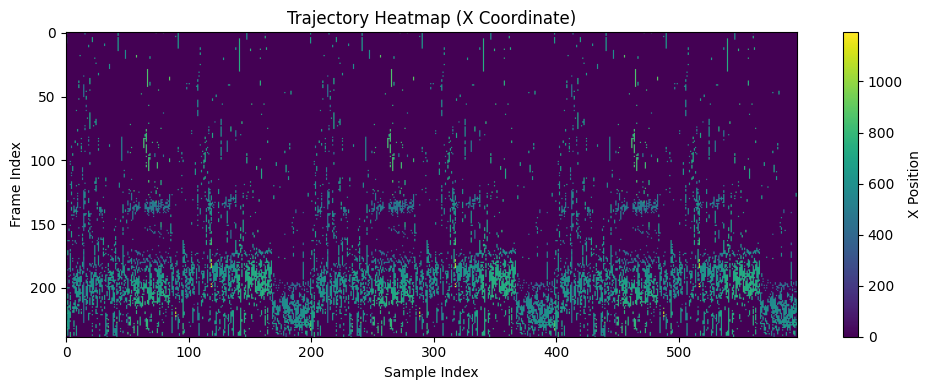

In [3]:
import matplotlib.pyplot as plt
import numpy as np
all_ball_x = pd.DataFrame([
    [item[1] if item is not None and len(item) > 1 else np.nan for item in one_trajectory]
    for one_trajectory in df['trajectory']
]).T

# 轉成 float array，並將所有 NaN 值用 0 或其他值填補
img = all_ball_x.astype(float).fillna(0).values

plt.figure(figsize=(10, 4))
plt.imshow(img, aspect='auto', cmap='viridis')
plt.colorbar(label='X Position')
plt.title("Trajectory Heatmap (X Coordinate)")
plt.xlabel("Sample Index")
plt.ylabel("Frame Index")
plt.tight_layout()
plt.show()

初步觀察大概200偵左右數據比較多 可能是偵測到棒球了 以下用統計的方式 找出 最容易偵測到棒球的那一偵

In [10]:
ball_presence = all_ball_x.notna().astype(int).sum(axis=1)
ball_presence.sort_values(ascending=False).head(10)

,0
196,291
194,288
198,279
197,273
199,273
200,267
193,261
204,258
203,258
202,258


In [11]:
196/60

3.2666666666666666

原來是196偵 196/60 = 3.26 也就是說差不多在影片3.26秒會偵測到棒球

可以發現大概在第196偵附近 數據開始出現比較密集 可能是投球 為了驗證 隨便撈幾部影片 觀察196偵畫面

到這個資料夾裡面/content/drive/MyDrive/Baseball Movies/Yu_Darvish_FF_videos_4S

隨機把幾部底下的mp4影片讀進來並在第200偵

使用baseballcv ball_tracking模型

信心度設置0.5去偵測棒球

In [12]:
#如果沒安裝請安裝
#!pip install ultralytics
#!pip install baseballcv

# 驗證196偵是否真的抓到棒球

2025-06-17 13:07:45,080 - LoadTools - INFO - Model found at models/od/YOLO/ball_tracking/model_weights/ball_tracking.pt


INFO:LoadTools:Model found at models/od/YOLO/ball_tracking/model_weights/ball_tracking.pt



0: 384x640 (no detections), 3318.4ms
Speed: 4.1ms preprocess, 3318.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
✅ pitch_0088.mp4 - 第 196 幀 棒球偵測結果：


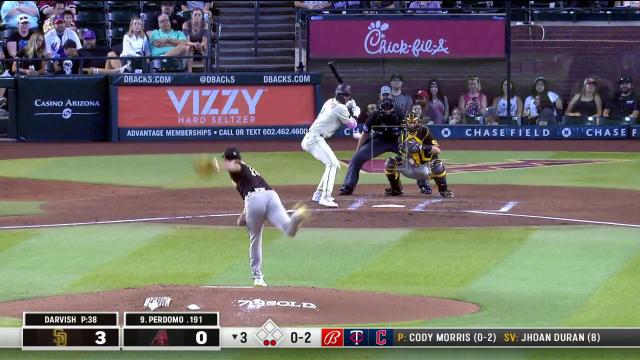


0: 384x640 1 baseball, 3192.3ms
Speed: 3.5ms preprocess, 3192.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
✅ pitch_0003.mp4 - 第 196 幀 棒球偵測結果：


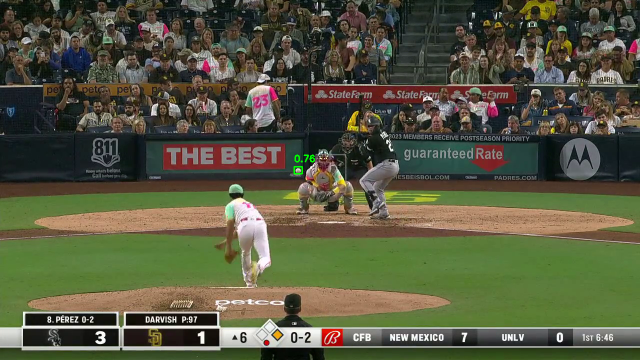


0: 384x640 1 baseball, 4262.5ms
Speed: 8.4ms preprocess, 4262.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
✅ pitch_0081.mp4 - 第 196 幀 棒球偵測結果：


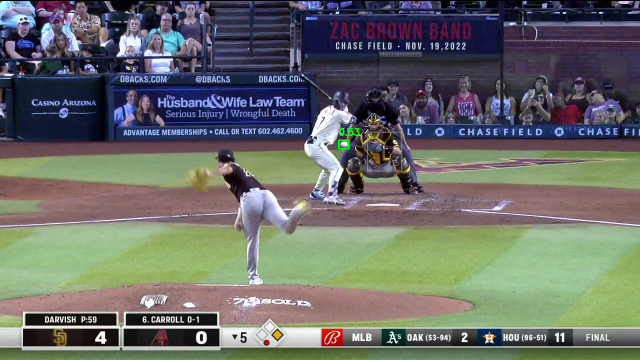


0: 384x640 1 baseball, 1 rubber, 3182.5ms
Speed: 4.2ms preprocess, 3182.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
✅ pitch_0122.mp4 - 第 196 幀 棒球偵測結果：


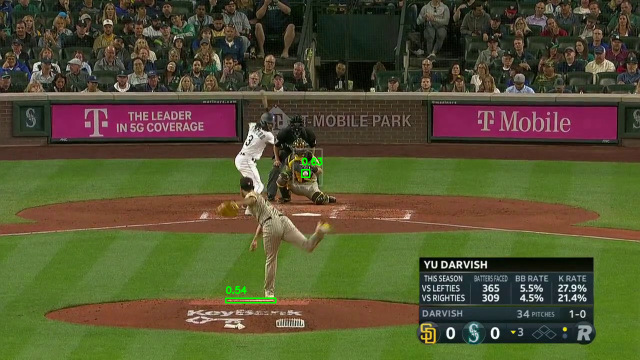


0: 384x640 1 baseball, 3197.5ms
Speed: 3.6ms preprocess, 3197.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
✅ pitch_0044.mp4 - 第 196 幀 棒球偵測結果：


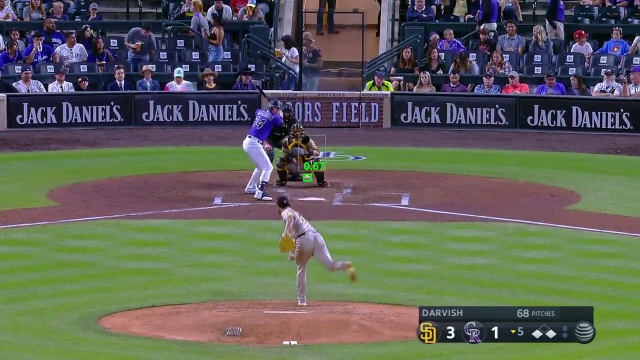

In [16]:
import os
import cv2
import random
from baseballcv.functions import LoadTools
from ultralytics import YOLO
from google.colab.patches import cv2_imshow  # 如果在 Colab 上使用

# 指定資料夾
folder_path = "/content/drive/MyDrive/Baseball Movies/Yu_Darvish_FF_videos_4S"

# 隨機選幾部影片
all_videos = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
selected_videos = random.sample(all_videos, 5)

# 載入模型
load_tools = LoadTools()
model_path = load_tools.load_model("ball_tracking")
model = YOLO(model_path)

# 信心度閾值
conf_threshold = 0.5

# 偵測每部影片的第 196 幀
for video_name in selected_videos:
    video_path = os.path.join(folder_path, video_name)
    cap = cv2.VideoCapture(video_path)

    # 跳到第 196 幀
    cap.set(cv2.CAP_PROP_POS_FRAMES, 196)
    success, frame = cap.read()
    cap.release()

    if not success:
        print(f"⚠️ 無法讀取 {video_name} 的第 196 幀")
        continue

    # 使用 YOLO 模型進行推論
    results = model.predict(frame, conf=conf_threshold)

    # 畫出偵測框（只顯示置信度 > 0.5）
    annotated_frame = frame.copy()
    for r in results:
        for box in r.boxes:
            if box.conf < conf_threshold:
                continue
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated_frame, f"{conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    print(f"✅ {video_name} - 第 196 幀 棒球偵測結果：")
    # 假設 annotated_frame 是原始圖
    scale_percent = 50  # 縮小為原來的 30%

    # 取得縮小後的尺寸
    width = int(annotated_frame.shape[1] * scale_percent / 100)
    height = int(annotated_frame.shape[0] * scale_percent / 100)
    resized_frame = cv2.resize(annotated_frame, (width, height), interpolation=cv2.INTER_AREA)

    # 顯示縮小後的圖
    cv2_imshow(resized_frame)


# 觀察過X座標 那把y座標也拿出來觀察

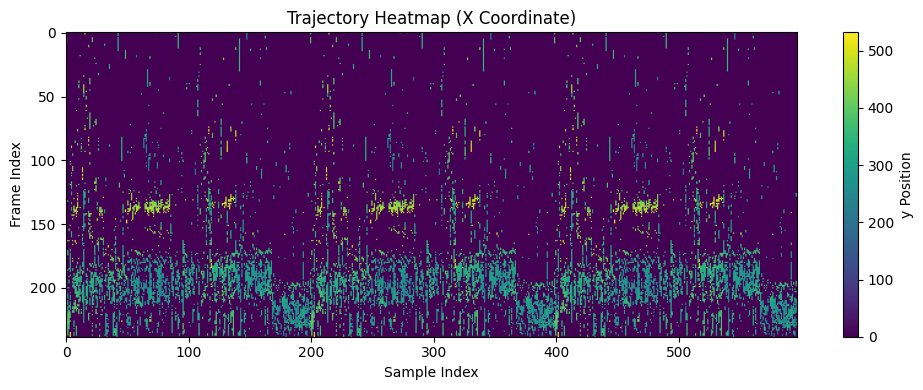

In [17]:
import numpy as np
all_ball_y = pd.DataFrame([
    [item[2] if item is not None and len(item) > 1 else np.nan for item in one_trajectory]
    for one_trajectory in df['trajectory']
]).T

# 轉成 float array，並將所有 NaN 值用 0 或其他值填補
img = all_ball_y.astype(float).fillna(0).values

plt.figure(figsize=(10, 4))
plt.imshow(img, aspect='auto', cmap='viridis')
plt.colorbar(label='y Position')
plt.title("Trajectory Heatmap (X Coordinate)")
plt.xlabel("Sample Index")
plt.ylabel("Frame Index")
plt.tight_layout()
plt.show()

看起來也跟x座標的分布差不多 密集分布在196偵左右

合併兩個座標 每個樣本會有 4秒 x239偵 y239偵 +1個label

所以是239+239+1 = 478+1 = 479個columns

In [18]:
XY = pd.concat([all_ball_x.T.iloc[:,:],all_ball_y.T.iloc[:,:]],axis=1)
XY['label'] = df['description'].str.lower().apply(lambda x: 1 if 'strike' in x or 'foul' in x else 0)
XY

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,label
0,669.0,669.5,NaN,NaN,670.0,669.5,669.5,669.5,669.5,NaN,...,323.0,NaN,294.5,283.5,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,395.5,395.5,395.5,395.0,395.5,395.5,395.5,395.5,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,343.5,343.5,343.0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,480.5,494.0,508.0,522.5,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,292.0,NaN,NaN,NaN,307.5,311.0,315.0,NaN,NaN,0
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262.0,264.0,NaN,NaN,271.0,274.5,278.5,279.5,NaN,1
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


接下來希望建立一個模型 單純從球路座標xy資料去 分類好壞球 考慮到有異常值 所以用隨機森林

✅ 為什麼隨機森林對異常值不敏感？
🌲 1. 非參數模型，無需資料分布假設
隨機森林（Random Forest）屬於非參數模型，不對輸入特徵的分布作假設，這意味著：

它不會像線性模型一樣受極端值影響係數估計

不使用歐幾里得距離或相似度計算，因此異常值不會在計算過程中主導結果

✂️ 2. 決策邏輯是「切割空間」不是「距離衡量」
隨機森林是由許多決策樹組成，每棵樹會根據特徵值的閾值來「劃分區域」（類似一刀切）：

每個節點只看單一特徵是否大於某值

異常值只會被分到某一邊的葉節點，不會影響其他樣本的分類

多棵樹的結果經過 Bagging（多模型投票平均），進一步稀釋了異常點的影響力

🔍 3. 與距離/相似度模型比較（KNN / SVM）
模型	對異常值敏感原因
KNN	基於距離判斷最近的鄰居 → 異常值會偏離群體，拉歪距離
SVM	嘗試最大化邊界 → 異常值會使 margin 被扭曲
隨機森林	使用特徵閾值分割，無距離概念 → 較不會被單點主導

# 建立隨機森林模型

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1. 準備資料：補 NaN 值為 0
X_filled = XY.drop(columns=['label']).fillna(0).values
y = XY['label'].values

# 2. 分訓練測試集
X_train, X_test, y_train, y_test = train_test_split(
    X_filled, y, test_size=0.2, random_state=42
)

# 3. 建立隨機森林模型
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# 訓練資料準確度

In [20]:
# 4. 預測與評估
y_pred = clf.predict(X_train)

print("🎯 Accuracy:", accuracy_score(y_train, y_pred))
print("\n🧾 Classification Report:\n", classification_report(y_train, y_pred))
print("\n🌀 Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

🎯 Accuracy: 1.0

🧾 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00       266

    accuracy                           1.00       477
   macro avg       1.00      1.00      1.00       477
weighted avg       1.00      1.00      1.00       477


🌀 Confusion Matrix:
 [[211   0]
 [  0 266]]


# 測試資料準確度

In [21]:
# 4. 預測與評估
y_pred = clf.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🌀 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

🎯 Accuracy: 0.975

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        50
           1       1.00      0.96      0.98        70

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120


🌀 Confusion Matrix:
 [[50  0]
 [ 3 67]]
